# Part 2 - Refine Data

In [28]:
dwh_basedir = "file:///srv/jupyter/nyc-dwh"
structured_basedir = dwh_basedir + "/structured"
refined_basedir = dwh_basedir + "/refined"

# 0 Create Spark Session

Before we begin, we create a local Spark session

## 0.1 Spark Session

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [3]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory","64G") \
    .getOrCreate()
spark.version

'2.4.3'

## 0.2 Matplotlib

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 1 Read Taxi Data

Now we can read in the taxi data from the structured zone.

## 1.1 Trip Data

In [4]:
trip_data = spark.read.parquet(structured_basedir + "/taxi-trip")
trip_data.limit(10).toPandas()

medallion                      hack_license  \
0  9406D2C34715E1DA10AD4D4DDADF4DA5  0602DFD837433635FE860BDE2F14BC3A   
1  73495B48481E673AD8D7578764C9EC98  66DA261DA2E0305435786C152085CCC2   
2  85B6168FC88F4914E4741015B1678BF4  C2DB36C1124AB69269DBE1D3D39D37DB   
3  85B6168FC88F4914E4741015B1678BF4  C2DB36C1124AB69269DBE1D3D39D37DB   
4  8C6CFF1ED34957DCF1547C3C38EE0490  65AB951A1B846C3B0581A8A473830F73   
5  25543063A418CEEBB75EE2F4D358CFF5  194EB4D4E0FC4B729E7CFAE0D0A4C1A2   
6  9B375E774BDAA8CC45CE6F3BF072C1E2  F01341355389BD2DCF5B085EF7F1BED3   
7  EA7677FAD8263B351D45713DC275BBB1  33BB6B238582DC4B1D569B631F646164   
8  185DB975730A99E17D05E4BFDA3888F2  D2FC0D6BA6B716B14B1D0654658DFB2C   
9  EE07B576CBB5EB2F5C8C8B27AC3B7624  F8A6B1EE8DA80763DD0929C2D4C0B0B2   

  vendor_id rate_code store_and_fwd_flag     pickup_datetime  \
0       VTS         1               None 2013-07-01 01:47:00   
1       VTS         1               None 2013-07-01 01:39:00   
2       VTS         1               None 2013-07-01 01:36:00   
3       VTS         1               None 2013-07-01 01:53:00   
4       VTS         1               None 2013-07-01 01:47:00   
5       VTS         1               None 2013-07-01 01:54:00   
6       VTS         1               None 2013-07-01 01:56:00   
7       VTS         1               None 2013-07-01 01:57:00   
8       VTS         1               None 2013-07-01 01:56:00   
9       VTS         1               None 2013-07-01 01:41:00   

     dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0 2013-07-01 01:52:00                1                300           1.17   
1 2013-07-01 01:52:00                1                780           4.17   
2 2013-07-01 01:50:00                1                840           2.98   
3 2013-07-01 01:57:00                1                240           0.75   
4 2013-07-01 01:59:00                1                720           1.76   
5 2013-07-01 01:58:00                1                240           1.54   
6 2013-07-01 02:02:00                5                360           1.82   
7 2013-07-01 02:01:00                1                240           1.25   
8 2013-07-01 02:00:00                4                240           0.98   
9 2013-07-01 01:59:00                1               1080          14.10   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  
0        -74.013229        40.714718         -74.003494         40.725285  
1        -73.980865        40.763947         -73.933884         40.767677  
2        -74.007568        40.740898         -73.980118         40.713985  
3        -73.985466        40.718342         -73.982841         40.727016  
4        -74.005630        40.726448         -74.003906         40.742031  
5        -74.006493        40.737938         -74.004990         40.752167  
6        -73.996078        40.759724         -74.007454         40.748444  
7        -73.991798        40.759712         -74.001923         40.750771  
8        -74.006699        40.739395         -74.008995         40.729649  
9        -73.782082        40.644661         -73.751389         40.777012

Just to be sure, let us inspect the schema. It should match exactly the specified one.

In [5]:
trip_data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



## 1.2 Fare information

Now we read in the second table containing the trips fare information.

In [6]:
fare_data = spark.read.parquet(structured_basedir + "/taxi-fare")
fare_data.limit(10).toPandas()

medallion                      hack_license  \
0  D1C79CF706C80D3A1DC7FBCA6CD56E43  DAC7742E8F00034774098DBC6B4FF2B7   
1  3567E8B49FEBFCBB587F1864D723D5C8  430B8022563CDE1D51D44786DFD8D6CB   
2  4220E1995D36A40DF34664AD33ED13F6  48A1C9C9300AFC7BDBB718CE308EE45A   
3  440900089FF528A873424DED689C77A3  E6A63B40E565A8A03AF32E0B138F5EB1   
4  16129167D9E7B0846DBA3D04B78E1B8D  227A03FC03CF429DFC9EAFF0AE8BA579   
5  46D8364DDA0DFC3B93D6E3F4B2C46CFB  02A0F797CE1D2464FA64565D0EF35A1D   
6  5643DA9CFC58C407A0B024777D5DA801  5EA6D1D297C81262654005AF14254986   
7  4233044C535D5D34B8E53D7C9AAB777F  98637FF1F9CE664844AA0866AF7F42A3   
8  41C45B896D091F7ACFDB856BBADF5806  4300DEAACCED3A8B5C810010C23D6799   
9  7D11B5EAD419CD87FCEAF8EFE87F5F75  75994990A1C546795A430B5EE51ABDD8   

  vendor_id     pickup_datetime payment_type  fare_amount  surcharge  mta_tax  \
0       CMT 2013-06-03 00:02:12          CRD          7.5        0.5      0.5   
1       CMT 2013-06-03 00:03:03          CRD         17.0        0.5      0.5   
2       CMT 2013-06-03 00:01:30          CRD         52.0        0.0      0.5   
3       CMT 2013-06-03 00:04:14          CRD         34.5        0.5      0.5   
4       CMT 2013-06-03 00:04:53          CRD          6.5        0.5      0.5   
5       CMT 2013-06-03 00:04:27          CRD         13.5        0.5      0.5   
6       CMT 2013-06-03 00:02:50          CRD          7.5        0.5      0.5   
7       CMT 2013-06-03 00:04:15          CRD         11.0        0.5      0.5   
8       CMT 2013-06-03 00:05:05          CRD          6.5        0.5      0.5   
9       CMT 2013-06-03 00:08:29          CRD          9.0        0.5      0.5   

   tip_amount  tolls_amount  total_amount  
0        2.12          0.00         10.62  
1        3.60          0.00         21.60  
2        5.00          5.33         62.83  
3        7.10          0.00         42.60  
4        1.50          0.00          9.00  
5        2.90          0.00         17.40  
6        1.50          0.00         10.00  
7        1.80          0.00         13.80  
8        1.50          0.00          9.00  
9        2.00          0.00         12.00

In [7]:
fare_data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



## 1.3 Join datasets

We can now join both the trip information and the fare information together in order to get a complete picture. Since the trip records do not contain a technical unique key, we use the following columns as the composite primary key of each trip:
* medallion
* hack_license
* vendor_id
* pickup_datetime

In [11]:
taxi_trips = trip_data.join(trip_fare,["medallion", "hack_license", "vendor_id", "pickup_datetime"], how="left_outer")
taxi_trips.write.parquet(refined_basedir + "/taxi_trip")

In [29]:
taxi_trips = spark.read.parquet(refined_basedir + "/taxi-trip")
taxi_trips.limit(10).toPandas()

medallion                      hack_license  \
0  00005007A9F30E289E760362F69E4EAD  0938A8DBC34197F8F91F700E3015A7A2   
1  00005007A9F30E289E760362F69E4EAD  0FD461760B482C0B229B3E98A2914819   
2  00005007A9F30E289E760362F69E4EAD  16780B3E72BAA7A5C152C197919DCA0E   
3  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   
4  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   
5  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   
6  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   
7  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   
8  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   
9  00005007A9F30E289E760362F69E4EAD  24C122A944FB8EE21D570C7067400D6F   

  vendor_id     pickup_datetime rate_code store_and_fwd_flag  \
0       CMT 2013-07-16 09:21:09         1                  N   
1       CMT 2013-10-27 23:40:08         1                  N   
2       CMT 2013-07-16 19:55:27         1                  N   
3       CMT 2013-10-08 08:37:48         1                  N   
4       CMT 2013-10-18 13:49:19         1                  N   
5       CMT 2013-10-28 13:39:04         1                  N   
6       CMT 2013-10-30 08:27:05         1                  N   
7       CMT 2013-11-06 07:42:33         1                  N   
8       CMT 2013-11-15 11:41:42         1                  N   
9       CMT 2013-12-09 06:22:15         1                  N   

     dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  ...  \
0 2013-07-16 09:30:51                1                582            1.6  ...   
1 2013-10-27 23:44:37                2                268            1.1  ...   
2 2013-07-16 20:17:49                1               1341            5.6  ...   
3 2013-10-08 08:51:42                2                833            1.9  ...   
4 2013-10-18 14:15:40                1               1580            3.1  ...   
5 2013-10-28 13:58:48                1               1184            1.8  ...   
6 2013-10-30 08:37:00                2                595            1.5  ...   
7 2013-11-06 07:57:27                1                893            3.9  ...   
8 2013-11-15 11:49:49                1                487            1.2  ...   
9 2013-12-09 06:39:43                1               1048            8.4  ...   

   pickup_latitude  dropoff_longitude  dropoff_latitude  payment_type  \
0        40.779961         -73.971527         40.758743           CRD   
1        40.751877         -73.990974         40.750546           CRD   
2        40.756721         -73.992645         40.693542           CRD   
3        40.786240         -73.957230         40.782959           CRD   
4        40.750698         -73.956955         40.780392           CSH   
5        40.764244         -73.994011         40.742683           CRD   
6        40.763229         -73.985291         40.747501           CSH   
7        40.755318         -74.013184         40.715298           CRD   
8        40.758041         -73.985641         40.746239           CSH   
9        40.748840         -73.870552         40.773499           CRD   

  fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0         8.5        0.0      0.5        3.00          0.00         12.00  
1         5.5        0.5      0.5        1.30          0.00          7.80  
2        19.5        1.0      0.5        4.20          0.00         25.20  
3        11.0        0.0      0.5        3.00          0.00         14.50  
4        18.0        0.0      0.5        0.00          0.00         18.50  
5        13.5        0.0      0.5        2.80          0.00         16.80  
6         8.5        0.0      0.5        0.00          0.00          9.00  
7        14.0        0.0      0.5        2.90          0.00         17.40  
8         7.5        0.0      0.5        0.00          0.00          8.00  
9        24.5        0.0      0.5        6.06          5.33  

In [30]:
taxi_trips.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [31]:
taxi_trips.count()

173185091

# 2. Weather Data

## 2.1 Weather Data

We already have weather data, but only individual measurements. We do not know how many measurements there are per hour and per day, so the raw table is not very useable for joining. Instead we'd like to have an hourly and a daily weather table containing average temperature, wind speed and precipitation. Since we are only interested in the year 2013, we also only load that specific year.

In [9]:
weather = spark.read.parquet(structured_basedir + "/weather/2013")
weather.limit(10).toPandas()

usaf   wban                  ts report_type wind_direction  \
0  999999  53159 2013-01-01 00:00:00       CRN05            999   
1  999999  53159 2013-01-01 00:05:00       CRN05            999   
2  999999  53159 2013-01-01 00:10:00       CRN05            999   
3  999999  53159 2013-01-01 00:15:00       CRN05            999   
4  999999  53159 2013-01-01 00:20:00       CRN05            999   
5  999999  53159 2013-01-01 00:25:00       CRN05            999   
6  999999  53159 2013-01-01 00:30:00       CRN05            999   
7  999999  53159 2013-01-01 00:35:00       CRN05            999   
8  999999  53159 2013-01-01 00:40:00       CRN05            999   
9  999999  53159 2013-01-01 00:45:00       CRN05            999   

  wind_direction_qual wind_observation  wind_speed wind_speed_qual  \
0                   9                9       999.9               9   
1                   9                9       999.9               9   
2                   9                9       999.9               9   
3                   9                9       999.9               9   
4                   9                9       999.9               9   
5                   9                9       999.9               9   
6                   9                9       999.9               9   
7                   9                9       999.9               9   
8                   9                9       999.9               9   
9                   9                9       999.9               9   

   air_temperature air_temperature_qual       AAD  precipitation_hours  \
0             -0.4                    1  01000091                  1.0   
1             -0.6                    1      None                  NaN   
2             -0.7                    1      None                  NaN   
3             -0.6                    1      None                  NaN   
4             -0.8                    1      None                  NaN   
5             -0.9                    1      None                  NaN   
6             -1.1                    1      None                  NaN   
7             -0.9                    1      None                  NaN   
8             -0.7                    1      None                  NaN   
9             -0.6                    1      None                  NaN   

   precipitation_depth        date  
0                  0.0  2013-01-01  
1                  NaN  2013-01-01  
2                  NaN  2013-01-01  
3                  NaN  2013-01-01  
4                  NaN  2013-01-01  
5                  NaN  2013-01-01  
6                  NaN  2013-01-01  
7                  NaN  2013-01-01  
8                  NaN  2013-01-01  
9                  NaN  2013-01-01

## 2.2 Calculate derived metrics and deduplicate data

We now want to join the weather data to the taxi trips. Since there might be multiple entries in the weather measurement table for a single hour, we deduplicate the data and aggregate it to a single hour.

In [22]:
hourly_weather = weather \
    .withColumn("date", f.to_date(weather["ts"])) \
    .withColumn("hour", f.hour(weather["ts"])) \
    .groupBy("usaf", "wban", "date", "hour").agg( 
        f.avg(f.when(weather["wind_speed_qual"] != 9, weather["wind_speed"])).alias("wind_speed"),
        f.avg(f.when(weather["air_temperature_qual"] != 9, weather["air_temperature"])).alias("temperature"),
        f.avg(f.when(weather["precipitation_hours"] == 1, weather["precipitation_depth"])).alias("precipitation")
    )

hourly_weather.limit(10).toPandas()

usaf   wban        date  hour  wind_speed  temperature  precipitation
0  083600  99999  2013-01-01     0    3.850000     7.000000            NaN
1  722500  12919  2013-01-01     0    7.533333    22.866667            0.0
2  999999  63894  2013-01-01     0         NaN     7.466667            0.0
3  722101  03039  2013-01-01     0    7.750000   -15.000000            3.0
4  720284  04877  2013-01-01     0    3.100000    -0.600000            NaN
5  723544  03954  2013-01-01     0    3.475000     3.975000            0.0
6  076670  99999  2013-01-01     0    1.800000     7.200000            NaN
7  727584  94038  2013-01-01     0    1.500000    -9.400000            0.0
8  725985  24267  2013-01-01     0         NaN          NaN            NaN
9  260630  99999  2013-01-01     0    3.500000     1.950000            NaN

In addition to the hourly metrics, we also preaggregate the data to daily records.

In [23]:
daily_weather = hourly_weather.groupBy("usaf", "wban", "date")\
    .agg(
        f.avg("temperature").alias("temperature"),
        f.avg("wind_speed").alias("wind_speed"),
        f.sum("precipitation").alias("precipitation"),
    )

daily_weather.limit(10).toPandas()

usaf   wban        date  temperature  wind_speed  precipitation
0  764593  99999  2013-01-01    17.666667    3.095833            0.0
1  411400  99999  2013-01-01    28.229167    3.129167            NaN
2  077530  99999  2013-01-01    10.945833    2.012500           10.0
3  076030  99999  2013-01-01     9.662500    2.591667          100.0
4  638200  99999  2013-01-01    29.034783    3.647826            NaN
5  997996  99999  2013-01-01    -3.304167    3.475000            NaN
6  834240  99999  2013-01-01    26.458333    1.884722            NaN
7  203530  99999  2013-01-01   -15.657143   11.857143            NaN
8  027450  99999  2013-01-01    -2.891667    1.916667            NaN
9  478120  99999  2013-01-01     7.912500    4.191667            NaN

### Save Preaggregated Weather

Finally we save both tables (hourly and daily weather), so we can directly reuse the data in the next steps.

In [35]:
hourly_weather.write.parquet(refined_basedir + "/weather-hourly/2013")
daily_weather.write.parquet(refined_basedir + "/weather-daily/2013")

## 2.3 Reload Data and draw Pictures

Now let us reload the data (just to make sure everything worked out nicely) and let's draw some pictures. We use a single station (which, by pure incident, is a weather station in NYC)

In [37]:
daily_weather = spark.read.parquet(refined_basedir + "/weather-daily/2013")

In [38]:
nyc_station_usaf = "725053"
nyc_station_wban = "94728"

pdf = daily_weather \
    .filter((daily_weather["usaf"] == nyc_station_usaf) & (daily_weather["wban"] == nyc_station_wban)) \
    .orderBy("date") \
    .toPandas()

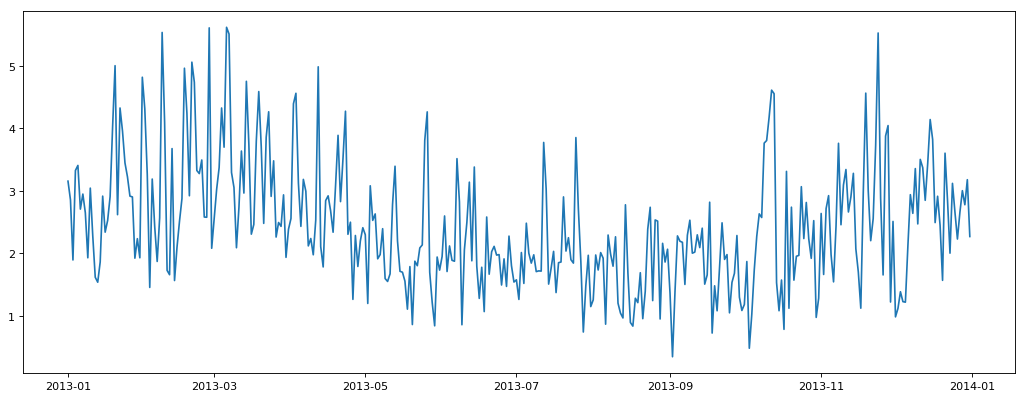

In [39]:
# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["wind_speed"])

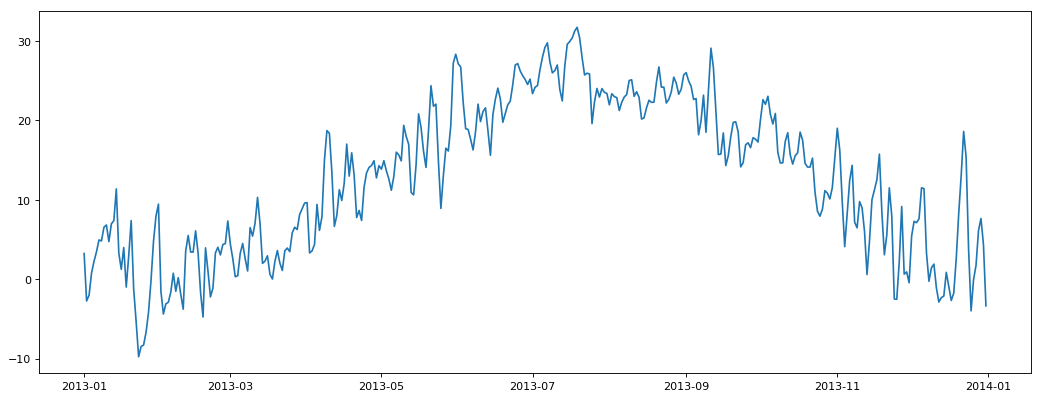

In [40]:
# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["temperature"])

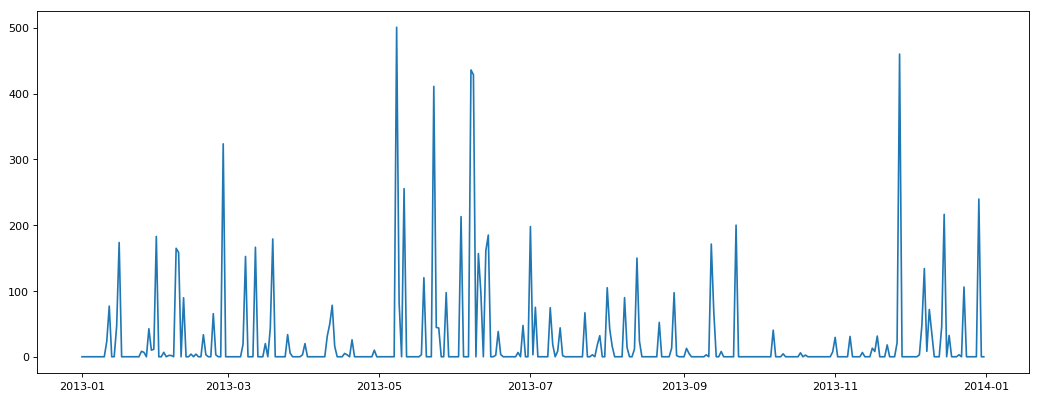

In [41]:
# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["precipitation"])